### MiniRAST Analysis

This is just an example of a couple of fields so we can identify which countries are important. See `RAST Sources` for a full notebook 

In [1]:
# some of these are not needed!
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

from PhiSpyAnalysis import theils_u, DateConverter


import subprocess
import gzip


In [2]:
phagesdf = read_phages()

Please note that this was run with git commit 46ed9e5 that has 567,404 genomes parsed.
Initially there were 3,265,453 kept phages,but after filtering we kept 1,293,084 prophages from 176,702 genomes

### The assembly accession ID column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [6]:
acccol = 'assembly_accession'

In [3]:
metadf = read_metadata()

## Read some categories

In [4]:
catdf = read_categories()
catdf

,assembly_accession,Category,Biome
0,GCA_000003645.1,food,Terrestrial
1,GCA_000003925.1,soil,Terrestrial
2,GCA_000003955.1,human blood,Host-Associated
3,GCA_000005825.2,soil,Terrestrial
4,GCA_000006155.2,human other,Host-Associated
...,...,...,...
54640,GCA_902860175.1,built environment,Terrestrial
54641,GCA_902860185.1,human other,Host-Associated
54642,GCA_902860195.1,human other,Host-Associated
54643,GCA_902860235.1,plant,Terrestrial


In [7]:
interesting_cols = [acccol, 'isolation_country', 'isolation_date']

tempdf = metadf[interesting_cols]
# tempdf = metadf[few_interesting_cols]
temp1 = pd.merge(tempdf, catdf, how='left', left_on=acccol, right_on=acccol)
# phagemeta = pd.merge(tempdf, phagesdf, how='inner', left_on=acccol, right_on=acccol)
# phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

phagemeta = pd.merge(temp1, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta

,assembly_accession,isolation_country,isolation_date,Category,Biome,assembly_name,Genome length,Contigs,Phage Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,NaN,NaN,NaN,NaN,ASM313v1,2396359.0,114.0,10.0,16.0,2.0,1.0,13.0,48916.0
1,GCA_000271545.1,United States,2010.292266,other water,Aquatic,Pelosinus.strA11_v1.0,5063494.0,134.0,38.0,33.0,6.0,6.0,21.0,218936.0
2,GCA_000271945.1,NaN,NaN,NaN,NaN,PgingivalisW50v1.0,2242062.0,104.0,88.0,19.0,0.0,2.0,17.0,0.0
3,GCA_000272065.2,NaN,NaN,NaN,NaN,ASM27206v2,4820065.0,595.0,263.0,79.0,1.0,49.0,29.0,15425.0
4,GCA_000272085.2,NaN,NaN,NaN,NaN,ASM27208v2,5056409.0,296.0,161.0,69.0,3.0,36.0,30.0,48106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176697,GCA_904848645.1,Brazil,NaN,NaN,NaN,LMG_24235,9749118.0,161.0,84.0,48.0,5.0,25.0,18.0,167790.0
176698,GCA_905176665.1,NaN,2014.371663,NaN,NaN,D4_OalgB6SA,5465468.0,286.0,71.0,10.0,0.0,10.0,0.0,0.0
176699,GCA_905176675.1,NaN,2014.371663,NaN,NaN,G3_OalgB6SA,4272394.0,1048.0,179.0,11.0,0.0,9.0,2.0,0.0
176700,GCA_905176695.1,NaN,2014.371663,NaN,NaN,G1_OalgB6SA,3819172.0,8736.0,68.0,2.0,0.0,2.0,0.0,0.0


## Encode the data

In [8]:
pmenc = pd.DataFrame()
for c in ['isolation_country', 'Category']:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['isolation_date'] = phagemeta['isolation_date'].fillna(-1)
pmenc

,isolation_country,Category,isolation_date
0,-1,-1,-1.000000
1,166,34,2010.292266
2,-1,-1,-1.000000
3,-1,-1,-1.000000
4,-1,-1,-1.000000
...,...,...,...
176697,22,-1,-1.000000
176698,-1,-1,2014.371663
176699,-1,-1,2014.371663
176700,-1,-1,2014.371663


In [9]:
# print a list of the countries and their IDs for the LOGO analysis.
seen=set()
for index, row in phagemeta.iterrows():
    if pmenc.loc[index, 'isolation_country'] not in seen:
        print(f"{pmenc.loc[index, 'isolation_country']}\t{phagemeta.loc[index, 'isolation_country']}")
        seen.add(pmenc.loc[index, 'isolation_country'])

-1	nan
166	United States
10	Australia
75	Japan
67	India
49	Ethiopia
139	South Africa
62	Haiti
97	Mexico
121	Peru
141	South Korea
55	Germany
153	Thailand
140	South America
147	Sweden
143	Spain
17	Belgium
52	France
122	Philippines
107	Netherlands
30	China
22	Brazil
165	United Kingdom
14	Bangladesh
74	Italy
7	Argentina
131	Scotland
28	Chad
154	Togo
111	Niger
0	Afghanistan
109	New Zealand
128	Russia
2	Algeria
39	Democratic Republic of the Congo
93	Mali
170	Viet Nam
26	Cameroon
95	Mauritius
132	Senegal
19	Benin
24	Burkina Faso
79	Kiribati
72	Ireland
40	Denmark
164	United Arab Emirates
46	England
11	Austria
56	Ghana
44	Egypt
65	Hungary
5	Antarctica
152	Tanzania
9	Atlantic Ocean
90	Madagascar
117	Pakistan
27	Canada
29	Chile
92	Malaysia
135	Slovakia
119	Papua New Guinea
116	Pacific Ocean
15	Barbados
162	Uganda
148	Switzerland
71	Iraq
38	Czech Republic
123	Poland
136	Slovenia
21	Bosnia and Herzegovina
124	Portugal
66	Iceland
158	Turkey
70	Iran
23	Bulgaria
127	Romania
98	Moldova
87	Lithuania
114

# Split the data into testing and training sets.

We will keep these sets for later, and do Leave One Group Out (LOGO) validation on the data and use the test set to measure accuracy.

First, lets set out baseline

In [14]:
x_train, x_test, y_train, y_test = train_test_split(pmenc, phagemeta.Kept.values.ravel())
clf = RandomForestClassifier(random_state=42, n_estimators=1000, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
f1base = metrics.f1_score(y_test, y_pred, average='weighted')
print("f1: ", f1base)

Accuracy: 0.13167783411807316
f1:  0.08994755939385476


In [11]:
if False:
    logo = LeaveOneGroupOut()
    for trainidx, testidx in logo.split(x_train, y_train, groups=x_train):
        print(f"Leaving out {pd.unique(x_train.iloc[testidx].values)}: ", end="")
        clf.fit(x_train.iloc[trainidx].ravel().reshape(-1,1), y_train[trainidx])
        new_pred=clf.predict(x_test.ravel().reshape(-1,1))
        f1measure = metrics.f1_score(y_test, new_pred, average='weighted')
        print(f"f1 delta: {f1base - f1measure}")

In [15]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf

,feature,importance
2,isolation_date,0.576786
0,isolation_country,0.273433
1,Category,0.149781


In [16]:
def number_not_null(x):
    return phagemeta[phagemeta[x.feature].notnull()].shape[0]

fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf["Number of observations"] = impdf.apply(number_not_null, axis=1)
impdf

,feature,importance,Number of observations
2,isolation_date,0.576786,39069
0,isolation_country,0.273433,41945
1,Category,0.149781,19445


([0, 1, 2], [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

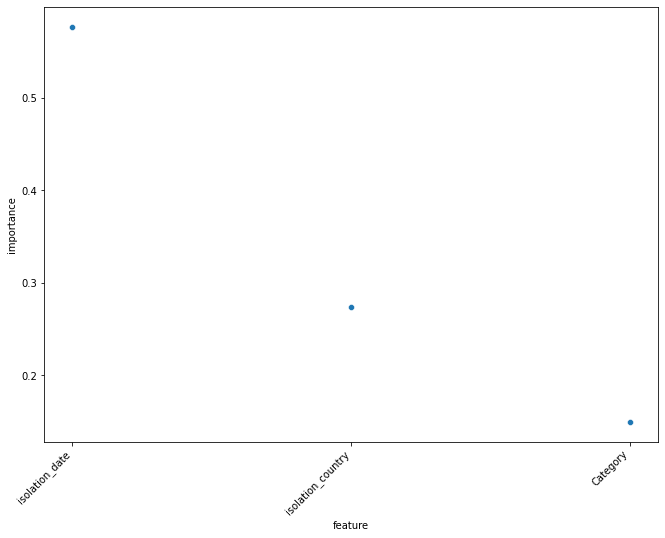

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')

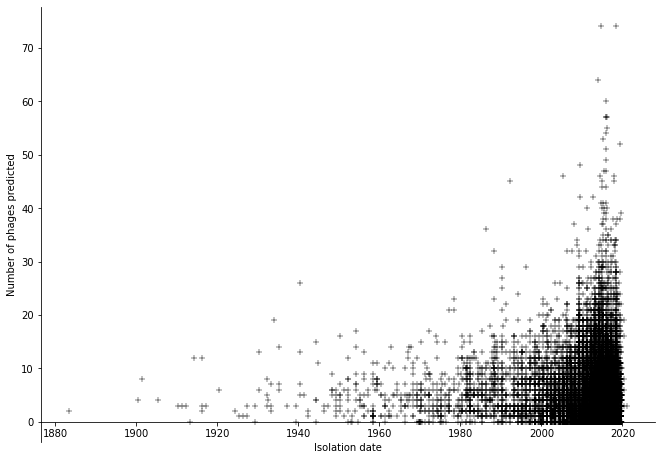

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='isolation_date', y='Kept', data=phagemeta[phagemeta['isolation_date'] != -1], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')



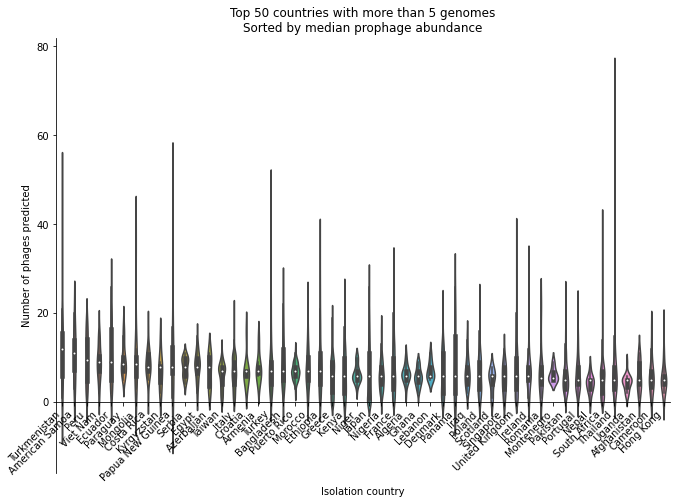

In [19]:
topnc = 50
genomen = 5 
tmpc = pd.DataFrame(phagemeta.groupby('isolation_country').count()['assembly_accession'] > genomen)
tmpc[tmpc['assembly_accession']].index
tmp = phagemeta[phagemeta['isolation_country'].isin(tmpc[tmpc['assembly_accession']].index)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
sortedorder = tmp.groupby('isolation_country')["Kept"].median().sort_values(ascending=False).index[0:topnc]
ax = sns.violinplot(x='isolation_country', y='Kept', data=tmp, ax=ax, order=sortedorder)
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation country")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title(f'Top {topnc} countries with more than {genomen} genomes\nSorted by median prophage abundance')
l = plt.xticks(rotation=45,  horizontalalignment='right')


## Big Question

Which country(s) are driving the importance of this measure in predicting the number of phages.